# Batch effect correction
> Runtime: about 3 min after loading the dataset.

The batch effect correction is illustrated on the POISED dataset, which contains 7 batches.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Scyan performs batch effect correction as the same time as training for cell-type annotations. Since these two tasks are linked, we advise the user to have already great annotations before to try batch effect correction. More precise annotations makes a better batch-effect correction. 
    </p>
</div>

In [1]:
import scyan

Global seed set to 0


In [2]:
adata, table = scyan.data.load("poised") # Load data (automatic)

## Amplify batch effect (skip this step on your data)
To illustrate batch effect correction on a more complex dataset, we amplify the batch effect. Skip this step, since you don't want to add extra noise.

In [3]:
import numpy as np

noise = np.random.exponential(
    scale=1, size=(7, adata.n_vars, adata.n_vars)
)

adata.X = scyan.preprocess.unscale(adata)
adata.X = scyan.preprocess.inverse_transform(adata)

for i, batch in enumerate(adata.obs.batch.cat.categories):
    spillover = np.eye(adata.n_vars) + 0.01 * noise[i]
    adata.X[adata.obs.batch == batch] = (
        adata.X[adata.obs.batch == batch] @ spillover
    )

scyan.preprocess.asinh_transform(adata)
scyan.preprocess.scale(adata)

In [ ]:
scyan.tools.umap(adata, markers=table.columns)

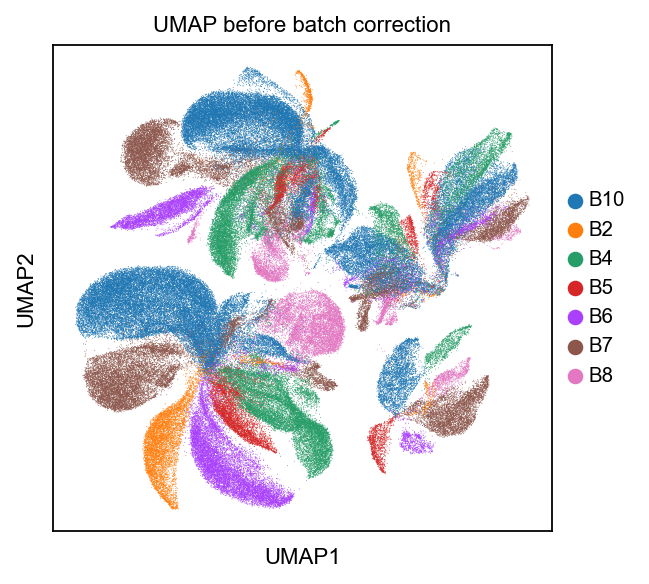

In [5]:
scyan.plot.umap(adata, color="batch", title="UMAP before batch correction")

## Correct batch effect

To correct the batch effect, you must have a column in `adata.obs` dedicated to the batch. Then, provide a `batch_key` to `scyan.Scyan`, i.e. the name of the column dedicated to the batch. You can also choose a `batch_ref`, i.e. one of all the batches you want to use, or let Scyan choose it for you (by default, the batch with the highest number of cells).

The batch knowledge is automatically added as one of the model `categorical_covariates`. You can add more categorical or continuous covariates if needed (see [scyan.Scyan API](../../api/model)).

> If you use your own dataset, use `Scyan` default parameters first.

In [6]:
# Only 'batch_key' is required for batch correction, you can use the default values for the parameters on the right
model = scyan.Scyan(adata, table, batch_key="batch", temperature=1.5, modulo_temp=3, prior_std=0.35, batch_size=4096, hidden_size=32, n_hidden_layers=6)

# For better batch effect correction, we advise to increase the default 'patience' and decrease 'min_delta'
# NB: if you have less than 1 million cells, you can also increase 'max_epochs'
model.fit(patience=10, min_delta=0.1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/scyan-5lsXrWE1-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 109 K 
---------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Scyan model with N=4178320 cells, P=26 populations and M=19 markers.
   ├── Covariates: batch
   └── Batch correction mode: True

After model training, we can align the distribution on a reference batch (here, `B10`).
> Note that corrected expressions are still preprocess and scaled. You can inserve these transformations with `scyan.preprocess.unscale` and `scyan.preprocess.inverse_transform`.

In [7]:
# Get observed marker expressions (warning: the corrected preprocess and standardised)
adata.obsm["scyan_corrected"] = model.batch_effect_correction().numpy(force=True)
scyan.tools.umap(adata, obsm="scyan_corrected");

DataLoader:   0%|          | 0/1021 [00:00<?, ?it/s]

DataLoader:   0%|          | 0/1021 [00:00<?, ?it/s]

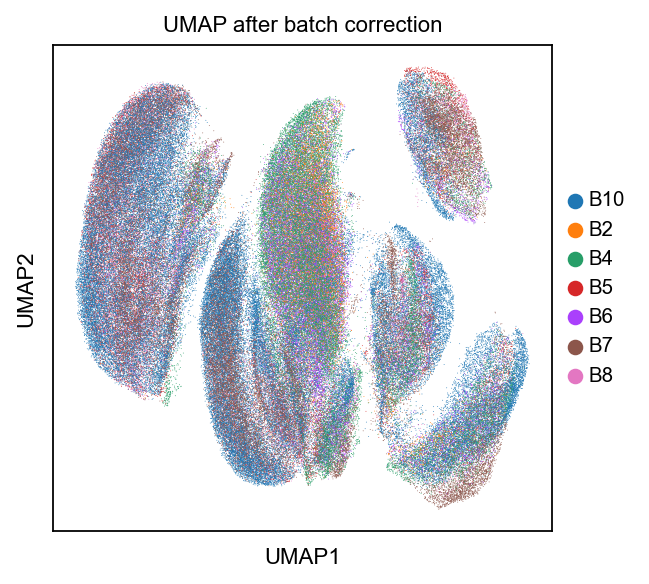

In [8]:
scyan.plot.umap(adata, color="batch", title="UMAP after batch correction")

## Handle NA markers

Sometimes, you will have a panel that includes some markers for which you have no prior knowledge at all. To handle batch effect correction for such markers, you can run `model.refine_fit()`.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Such markers have to be added in the table (if not done yet). Just add a column of NAs for each of these markers.
    </p>
</div>

In [ ]:
model.refine_fit()

Then run everything again

In [ ]:
adata.obsm["scyan_corrected"] = model.batch_effect_correction(batch_ref="B10").numpy(force=True)
scyan.tools.umap(adata, obsm="scyan_corrected");
scyan.plot.umap(adata, color="batch", title="UMAP after refined batch correction")

## Use batch corrected expressions for further analysis

The batch effect corrected expressions are stored in `adata.obsm["scyan_corrected"]`, and the corresponding marker names are in `model.var_names`. You can use them for further analysis.

In [ ]:
print(adata.obsm["scyan_corrected"])
print(f"Marker names: {', '.join(model.var_names)}")

You can also update `adata.X` and work on the unscaled data. Note that it only updates the markers that are in the table, so consider using them all if needed (see above).

In [ ]:
adata[:, model.var_names].X = adata.obsm["scyan_corrected"]
adata.X = scyan.preprocess.unscale(adata)